Proposed Parameters: {'x': 0.23878827919342266} ==> : 0.17644566226430292

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
import torch.nn.functional as F

import torchbnn as bnn

In [2]:
import numpy as np

In [3]:
import pickle
with open('tf_params_2.pickle', 'rb') as handle:
    gryffin_state = pickle.load(handle)


In [4]:
gryffin_state

{'observer_params': array([[ 4.85836357e-01],
        [ 9.81587648e-01],
        [ 1.01841235e+00],
        [ 2.70403601e-04],
        [-2.70403601e-04],
        [ 5.99545987e-01],
        [ 5.45285236e-01],
        [ 6.85413426e-01],
        [ 7.41004419e-01],
        [ 8.61206008e-01],
        [ 7.58100161e-01],
        [ 7.73971449e-01],
        [ 8.17559981e-01],
        [ 7.13215498e-01],
        [ 7.49508663e-01],
        [ 7.53811452e-01]]),
 'frac_feas': 1.0,
 'config': {'kernel_names': ['x'],
  'feature_sizes': array([1]),
  'feature_types': ['continuous'],
  'kernel_uppers': array([1.]),
  'kernel_lowers': array([0.]),
  'kernel_ranges': array([1.]),
  'kernel_sizes': array([1]),
  'kernel_types': ['continuous'],
  'param_name': ['x']},
 'model_details': {'bias_loc': 0.0,
  'bias_scale': 1.0,
  'hidden_shape': 6,
  'learning_rate': 0.05,
  'num_draws': 1000,
  'num_epochs': 2000,
  'num_layers': 3,
  'weight_loc': 0.0,
  'weight_scale': 1.0}}

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
len(gryffin_state['observer_params'])

16

In [7]:
def gen_training_data(gryffin_state):
        obs_params = gryffin_state['observer_params']
        feature_size = len(gryffin_state["config"]["kernel_names"])
        bnn_output_size = len(gryffin_state["config"]["kernel_names"])
        target_size = len(gryffin_state["config"]["kernel_names"])
        
        
        
        num_obs = len(obs_params)

        # initialize training features and targets
        features = np.zeros((num_obs, feature_size))
        targets = np.zeros((num_obs, target_size))

        # construct training features
        feature_begin = 0
        feature_sizes = gryffin_state["config"]["feature_sizes"]
        for feature_index, feature_type in enumerate(gryffin_state["config"]["feature_types"]):
            feature_size = feature_sizes[feature_index]
            if feature_type == 'categorical':
                for obs_param_index, obs_param in enumerate(obs_params):
                    features[obs_param_index, feature_begin + int(obs_param[feature_index])] += 1
            elif feature_type == 'discrete':
                for obs_param_index, obs_param in enumerate(obs_params):
                    features[obs_param_index, feature_begin + int(obs_param[feature_index])] += 1
            elif feature_type == 'continuous':
                features[:, feature_begin] = obs_params[:, feature_index]
            else:
                raise NotImplementedError
            feature_begin += feature_size
        targets = features.copy()

        # rescale features
        lower_rescalings = np.empty(feature_size)
        upper_rescalings = np.empty(feature_size)
        kernel_uppers, kernel_lowers = gryffin_state["config"]["kernel_uppers"], gryffin_state["config"]["kernel_lowers"]
        for kernel_index, kernel_name in enumerate(gryffin_state["config"]["kernel_names"]):
            low = kernel_lowers[kernel_index]
            up  = kernel_uppers[kernel_index]
            lower_rescalings[kernel_index] = low  # - 0.1 * (up - low)
            upper_rescalings[kernel_index] = up   # + 0.1 * (up - low)

        lower_rescalings = lower_rescalings
        upper_rescalings = upper_rescalings

        rescaled_features = (features - lower_rescalings) / (upper_rescalings - lower_rescalings)
        rescaled_targets = (targets - lower_rescalings) / (upper_rescalings - lower_rescalings)
        return (rescaled_features, rescaled_targets)

In [8]:
features, targets = gen_training_data(gryffin_state)

In [9]:
features

array([[ 4.85836357e-01],
       [ 9.81587648e-01],
       [ 1.01841235e+00],
       [ 2.70403601e-04],
       [-2.70403601e-04],
       [ 5.99545987e-01],
       [ 5.45285236e-01],
       [ 6.85413426e-01],
       [ 7.41004419e-01],
       [ 8.61206008e-01],
       [ 7.58100161e-01],
       [ 7.73971449e-01],
       [ 8.17559981e-01],
       [ 7.13215498e-01],
       [ 7.49508663e-01],
       [ 7.53811452e-01]])

In [10]:
targets

array([[ 4.85836357e-01],
       [ 9.81587648e-01],
       [ 1.01841235e+00],
       [ 2.70403601e-04],
       [-2.70403601e-04],
       [ 5.99545987e-01],
       [ 5.45285236e-01],
       [ 6.85413426e-01],
       [ 7.41004419e-01],
       [ 8.61206008e-01],
       [ 7.58100161e-01],
       [ 7.73971449e-01],
       [ 8.17559981e-01],
       [ 7.13215498e-01],
       [ 7.49508663e-01],
       [ 7.53811452e-01]])

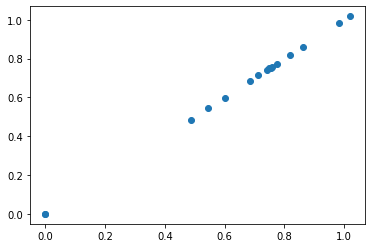

In [11]:
plt.scatter(features, targets)
plt.show()

In [12]:
# hidden_shape = gryffin_state['model_details']['hidden_shape']
# feature_size = len(gryffin_state["config"]["kernel_names"])
# bnn_output_size = len(gryffin_state["config"]["kernel_names"])

# model = nn.Sequential(
#     bnn.BayesLinear(prior_mu=0.0, prior_sigma=1.0, in_features=feature_size, out_features=hidden_shape, bias=True),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0.0, prior_sigma=1.0, in_features=hidden_shape, out_features=bnn_output_size, bias=True),
# )

In [50]:
class BNN(nn.Module):
    def __init__(self, gryffin_state):
        super(BNN, self).__init__()
        
        self.hidden_shape = gryffin_state['model_details']['hidden_shape']
        self.feature_size = len(gryffin_state["config"]["kernel_names"])
        self.bnn_output_size = len(gryffin_state["config"]["kernel_names"])
        self.num_obs = len(gryffin_state['observer_params'])
        self.frac_feas = gryffin_state['frac_feas']
        self.kernel_ranges = torch.tensor(gryffin_state["config"]["kernel_ranges"])
        self.kernel_uppers = torch.tensor(gryffin_state["config"]["kernel_uppers"])
        self.kernel_lowers = torch.tensor(gryffin_state["config"]["kernel_lowers"])
        self.kernel_types = gryffin_state["config"]["kernel_types"]
        self.kernel_sizes = torch.tensor(gryffin_state["config"]["kernel_sizes"])
        self.kernel_names = gryffin_state["config"]["kernel_names"]
#         self.kernel_ranges = gryffin_state["config"]["kernel_ranges"]
#         self.kernel_uppers = gryffin_state["config"]["kernel_uppers"]
#         self.kernel_lowers = gryffin_state["config"]["kernel_lowers"]
#         self.kernel_types = gryffin_state["config"]["kernel_types"]
#         self.kernel_sizes = gryffin_state["config"]["kernel_sizes"]
#         self.kernel_names = gryffin_state["config"]["kernel_names"]
        
        self.layers = nn.Sequential(
            bnn.BayesLinear(prior_mu=0.0, prior_sigma=1.0, in_features=self.feature_size, out_features=self.hidden_shape, bias=True),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=0.0, prior_sigma=1.0, in_features=self.hidden_shape, out_features=self.bnn_output_size, bias=True),
        )
        
        self.tau_rescaling = torch.tensor(np.zeros((self.num_obs, self.bnn_output_size)))
        for obs_index in range(self.num_obs):
            self.tau_rescaling[obs_index] += self.kernel_ranges
        self.tau_rescaling = self.tau_rescaling**2
        self.gamma_concentration = nn.Parameter(torch.zeros(self.num_obs, self.bnn_output_size) + 12*(self.num_obs/self.frac_feas)**2)
        self.gamma_rate = nn.Parameter(F.softplus(torch.ones(self.num_obs, self.bnn_output_size)))
        
        self.tau_normed = td.gamma.Gamma(self.gamma_concentration, self.gamma_rate)
        
        
    def forward(self, x, y):
    
        x = self.layers(x)
        
        scale = 1.0 / torch.sqrt(self.tau_normed.sample() / self.tau_rescaling)
        
        inferences = []
        kernel_element_index = 0
        target_element_index = 0
        while kernel_element_index < len(self.kernel_names):

                kernel_type = self.kernel_types[kernel_element_index]
                kernel_size = self.kernel_sizes[kernel_element_index]

                feature_begin, feature_end = target_element_index, target_element_index + 1
                kernel_begin, kernel_end   = kernel_element_index, kernel_element_index + kernel_size

                post_relevant  = x[:,  kernel_begin: kernel_end]
                
                target = y[:, kernel_begin: kernel_end]
                lowers, uppers = self.kernel_lowers[kernel_begin: kernel_end], self.kernel_uppers[kernel_begin : kernel_end]

                post_support = (uppers - lowers) * (1.2 * F.sigmoid(post_relevant) - 0.1) + lowers

                post_predict = td.normal.Normal(post_support,  scale[:,  kernel_begin: kernel_end])

            
                inference = {'pred': post_predict, 'target': target}
                inferences.append(inference)
                
                kernel_element_index += kernel_size
                target_element_index += 1
                
        return inferences
        
        
        
        

In [64]:
mse_loss = nn.MSELoss()
nll_loss = nn.NLLLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
model = BNN(gryffin_state)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [65]:
x = torch.tensor(features).float()
y = torch.tensor(targets)

for step in range(3000):
    pre = model(x, y)
#     print(pre[0])
    
    loss = 0.0
    for inference in pre:
        loss += - torch.sum(inference['pred'].log_prob(inference['target']))
    #mse = mse_loss(pre[0]['pred'], pre[0]['target'])
    kl = kl_loss(model)
    cost = loss + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    print('Loss : %2.2f, KL : %2.2f' % (loss.item(), kl.item()))
    #print('Loss : %2.2f' % (loss.item()))
 
# print('Final Loss : %2.2f, KL : %2.2f' % (loss.item(), kl.item()))

Loss : 11466.57, KL : 0.09
Loss : 5149.82, KL : 0.09
Loss : 2534.59, KL : 0.08
Loss : 6779.37, KL : 0.08
Loss : 2528.87, KL : 0.08
Loss : 10392.70, KL : 0.08
Loss : 2770.68, KL : 0.08
Loss : 7229.91, KL : 0.08
Loss : 3384.12, KL : 0.08
Loss : 8175.93, KL : 0.08
Loss : 1082.49, KL : 0.08
Loss : 5563.31, KL : 0.08
Loss : 1517.68, KL : 0.08
Loss : 2044.30, KL : 0.08
Loss : 9607.31, KL : 0.08
Loss : 755.39, KL : 0.08
Loss : 2438.29, KL : 0.08
Loss : 2313.95, KL : 0.08
Loss : 11980.25, KL : 0.08
Loss : 4905.90, KL : 0.08
Loss : 11705.01, KL : 0.08
Loss : 4423.01, KL : 0.08
Loss : 1383.63, KL : 0.08
Loss : 12032.01, KL : 0.08
Loss : 8427.03, KL : 0.08
Loss : 3055.76, KL : 0.08
Loss : 7316.90, KL : 0.08
Loss : 7393.26, KL : 0.08
Loss : 3682.95, KL : 0.08
Loss : 5837.85, KL : 0.08
Loss : 1834.44, KL : 0.09
Loss : 1418.29, KL : 0.09
Loss : 1461.99, KL : 0.09
Loss : 685.07, KL : 0.09
Loss : 574.54, KL : 0.09
Loss : 4509.80, KL : 0.09
Loss : 8567.36, KL : 0.09
Loss : 7284.82, KL : 0.09
Loss : 358

Loss : 3480.85, KL : 0.30
Loss : 1445.39, KL : 0.30
Loss : 1921.08, KL : 0.31
Loss : 1623.44, KL : 0.31
Loss : 2664.18, KL : 0.31
Loss : 2211.70, KL : 0.31
Loss : 1516.39, KL : 0.31
Loss : 1331.08, KL : 0.31
Loss : 4179.60, KL : 0.31
Loss : 1143.70, KL : 0.32
Loss : 2404.81, KL : 0.32
Loss : 1521.01, KL : 0.32
Loss : 1486.65, KL : 0.32
Loss : 1784.24, KL : 0.32
Loss : 1290.33, KL : 0.32
Loss : 1711.47, KL : 0.32
Loss : 1513.20, KL : 0.32
Loss : 854.39, KL : 0.32
Loss : 1460.52, KL : 0.32
Loss : 2061.29, KL : 0.32
Loss : 1506.96, KL : 0.32
Loss : 1770.90, KL : 0.32
Loss : 1488.76, KL : 0.32
Loss : 1536.75, KL : 0.33
Loss : 2651.53, KL : 0.33
Loss : 1571.08, KL : 0.33
Loss : 851.52, KL : 0.33
Loss : 1252.74, KL : 0.33
Loss : 2141.12, KL : 0.33
Loss : 1356.82, KL : 0.33
Loss : 1102.74, KL : 0.33
Loss : 1778.52, KL : 0.33
Loss : 1900.08, KL : 0.33
Loss : 1550.95, KL : 0.33
Loss : 1146.29, KL : 0.33
Loss : 999.46, KL : 0.33
Loss : 524.47, KL : 0.33
Loss : 2409.83, KL : 0.33
Loss : 2311.99, 

Loss : 1147.37, KL : 0.52
Loss : 990.25, KL : 0.52
Loss : 1426.07, KL : 0.52
Loss : 2699.87, KL : 0.52
Loss : 1351.80, KL : 0.52
Loss : 1461.22, KL : 0.52
Loss : 1439.83, KL : 0.52
Loss : 1390.85, KL : 0.52
Loss : 964.50, KL : 0.52
Loss : 978.98, KL : 0.53
Loss : 1939.09, KL : 0.53
Loss : 1206.08, KL : 0.53
Loss : 1061.53, KL : 0.53
Loss : 1428.64, KL : 0.53
Loss : 1162.59, KL : 0.53
Loss : 1432.57, KL : 0.53
Loss : 1304.94, KL : 0.53
Loss : 1505.14, KL : 0.53
Loss : 579.91, KL : 0.53
Loss : 684.07, KL : 0.53
Loss : 1695.76, KL : 0.53
Loss : 638.32, KL : 0.53
Loss : 1430.66, KL : 0.53
Loss : 626.07, KL : 0.54
Loss : 1290.88, KL : 0.54
Loss : 1168.18, KL : 0.54
Loss : 1011.89, KL : 0.54
Loss : 1280.90, KL : 0.54
Loss : 1430.08, KL : 0.54
Loss : 2410.58, KL : 0.54
Loss : 1418.27, KL : 0.54
Loss : 1163.62, KL : 0.54
Loss : 2104.32, KL : 0.54
Loss : 955.41, KL : 0.54
Loss : 1454.68, KL : 0.54
Loss : 263.70, KL : 0.54
Loss : 1319.78, KL : 0.54
Loss : 1205.67, KL : 0.54
Loss : 685.83, KL : 0

Loss : 345.39, KL : 0.94
Loss : 115.85, KL : 0.94
Loss : 192.28, KL : 0.94
Loss : 114.58, KL : 0.94
Loss : 269.68, KL : 0.94
Loss : 339.95, KL : 0.94
Loss : 271.70, KL : 0.94
Loss : 318.38, KL : 0.94
Loss : 221.66, KL : 0.95
Loss : 122.92, KL : 0.95
Loss : 524.04, KL : 0.95
Loss : 409.96, KL : 0.95
Loss : 155.62, KL : 0.95
Loss : 52.60, KL : 0.95
Loss : 824.61, KL : 0.95
Loss : 106.17, KL : 0.95
Loss : 243.15, KL : 0.95
Loss : 261.65, KL : 0.95
Loss : 2136.85, KL : 0.95
Loss : 165.47, KL : 0.96
Loss : 406.68, KL : 0.96
Loss : 311.92, KL : 0.96
Loss : 99.28, KL : 0.96
Loss : 181.45, KL : 0.97
Loss : 127.28, KL : 0.97
Loss : 108.28, KL : 0.97
Loss : 81.15, KL : 0.97
Loss : 103.34, KL : 0.97
Loss : 367.80, KL : 0.97
Loss : 152.37, KL : 0.97
Loss : 375.71, KL : 0.98
Loss : 289.59, KL : 0.98
Loss : 180.42, KL : 0.98
Loss : 198.48, KL : 0.98
Loss : 51.16, KL : 0.98
Loss : 224.17, KL : 0.98
Loss : 320.44, KL : 0.98
Loss : 107.66, KL : 0.98
Loss : 179.32, KL : 0.98
Loss : 54.53, KL : 0.98
Loss

Loss : 241.05, KL : 1.13
Loss : 111.34, KL : 1.13
Loss : 157.29, KL : 1.13
Loss : 84.53, KL : 1.13
Loss : 199.86, KL : 1.13
Loss : 163.66, KL : 1.13
Loss : 122.86, KL : 1.13
Loss : 108.62, KL : 1.13
Loss : 18.45, KL : 1.13
Loss : 31.14, KL : 1.13
Loss : 86.91, KL : 1.13
Loss : 170.55, KL : 1.13
Loss : 203.17, KL : 1.13
Loss : 150.88, KL : 1.13
Loss : 95.27, KL : 1.13
Loss : 73.17, KL : 1.13
Loss : 38.53, KL : 1.13
Loss : 136.48, KL : 1.13
Loss : 53.09, KL : 1.13
Loss : 362.39, KL : 1.13
Loss : 88.37, KL : 1.13
Loss : 46.81, KL : 1.13
Loss : 117.30, KL : 1.13
Loss : 98.13, KL : 1.13
Loss : 43.78, KL : 1.13
Loss : 210.37, KL : 1.13
Loss : 238.27, KL : 1.13
Loss : 176.45, KL : 1.14
Loss : 347.35, KL : 1.14
Loss : 156.03, KL : 1.14
Loss : 93.66, KL : 1.14
Loss : 69.59, KL : 1.14
Loss : 95.72, KL : 1.14
Loss : 117.88, KL : 1.14
Loss : 43.60, KL : 1.14
Loss : 51.76, KL : 1.14
Loss : 93.73, KL : 1.14
Loss : 34.82, KL : 1.14
Loss : 95.98, KL : 1.14
Loss : 147.68, KL : 1.14
Loss : 394.87, KL : 

Loss : 19.14, KL : 1.25
Loss : -4.99, KL : 1.25
Loss : -4.30, KL : 1.25
Loss : 19.84, KL : 1.25
Loss : 3.26, KL : 1.25
Loss : 71.79, KL : 1.25
Loss : 6.91, KL : 1.25
Loss : 112.60, KL : 1.25
Loss : 1.84, KL : 1.25
Loss : 50.10, KL : 1.25
Loss : 48.49, KL : 1.25
Loss : 42.74, KL : 1.25
Loss : 62.75, KL : 1.25
Loss : 68.44, KL : 1.25
Loss : -19.74, KL : 1.25
Loss : 349.75, KL : 1.25
Loss : 52.94, KL : 1.25
Loss : 61.74, KL : 1.25
Loss : 93.52, KL : 1.25
Loss : 46.21, KL : 1.25
Loss : 51.51, KL : 1.25
Loss : 24.56, KL : 1.25
Loss : 48.55, KL : 1.25
Loss : -4.65, KL : 1.25
Loss : 5.10, KL : 1.25
Loss : 143.90, KL : 1.25
Loss : -7.51, KL : 1.25
Loss : -7.50, KL : 1.25
Loss : -9.89, KL : 1.25
Loss : 8.63, KL : 1.25
Loss : 11.09, KL : 1.25
Loss : 18.31, KL : 1.26
Loss : 58.84, KL : 1.26
Loss : 47.23, KL : 1.26
Loss : 152.75, KL : 1.26
Loss : 230.35, KL : 1.26
Loss : -1.03, KL : 1.26
Loss : 11.89, KL : 1.26
Loss : 5.59, KL : 1.26
Loss : 126.05, KL : 1.26
Loss : 1.56, KL : 1.26
Loss : 52.06, KL

Loss : 57.77, KL : 1.39
Loss : 0.18, KL : 1.39
Loss : -19.62, KL : 1.39
Loss : 216.81, KL : 1.39
Loss : 0.86, KL : 1.39
Loss : 44.32, KL : 1.39
Loss : 89.85, KL : 1.39
Loss : 24.60, KL : 1.39
Loss : -16.70, KL : 1.39
Loss : 190.14, KL : 1.39
Loss : 16.02, KL : 1.39
Loss : 82.37, KL : 1.39
Loss : 29.23, KL : 1.39
Loss : -25.25, KL : 1.39
Loss : -13.08, KL : 1.39
Loss : 6.72, KL : 1.39
Loss : -20.38, KL : 1.39
Loss : 16.19, KL : 1.39
Loss : 55.27, KL : 1.39
Loss : -21.62, KL : 1.39
Loss : 94.95, KL : 1.39
Loss : 36.96, KL : 1.40
Loss : 32.59, KL : 1.40
Loss : 14.34, KL : 1.40
Loss : 1.22, KL : 1.40
Loss : 51.03, KL : 1.40
Loss : 24.45, KL : 1.40
Loss : 144.11, KL : 1.40
Loss : -18.74, KL : 1.40
Loss : -25.71, KL : 1.40
Loss : -26.00, KL : 1.40
Loss : 49.14, KL : 1.40
Loss : -14.34, KL : 1.40
Loss : 16.99, KL : 1.40
Loss : -14.03, KL : 1.40
Loss : -24.44, KL : 1.40
Loss : -23.20, KL : 1.40
Loss : -31.34, KL : 1.40
Loss : -25.70, KL : 1.40
Loss : -25.20, KL : 1.40
Loss : 17.72, KL : 1.40
L

Loss : -40.69, KL : 1.48
Loss : 19.97, KL : 1.48
Loss : -27.73, KL : 1.48
Loss : -9.71, KL : 1.48
Loss : -23.68, KL : 1.48
Loss : -24.80, KL : 1.48
Loss : -34.44, KL : 1.48
Loss : -22.37, KL : 1.48
Loss : -24.27, KL : 1.48
Loss : -25.66, KL : 1.48
Loss : -27.46, KL : 1.48
Loss : -14.21, KL : 1.48
Loss : -14.75, KL : 1.48
Loss : -24.19, KL : 1.48
Loss : 87.75, KL : 1.48
Loss : -7.92, KL : 1.48
Loss : -9.79, KL : 1.48
Loss : -27.48, KL : 1.48
Loss : -12.77, KL : 1.48
Loss : -31.61, KL : 1.48
Loss : -5.20, KL : 1.48
Loss : -1.25, KL : 1.48
Loss : -34.69, KL : 1.48
Loss : -30.34, KL : 1.48
Loss : -31.00, KL : 1.48
Loss : -25.43, KL : 1.48
Loss : -29.60, KL : 1.48
Loss : -34.51, KL : 1.48
Loss : 0.46, KL : 1.48
Loss : -33.40, KL : 1.48
Loss : -12.95, KL : 1.48
Loss : -26.07, KL : 1.48
Loss : 5.98, KL : 1.48
Loss : -31.97, KL : 1.48
Loss : 40.98, KL : 1.48
Loss : -30.27, KL : 1.48
Loss : -32.88, KL : 1.48
Loss : -37.30, KL : 1.48
Loss : -36.08, KL : 1.48
Loss : -31.64, KL : 1.48
Loss : -31.8

In [ ]:
output = multivariate_normal.MultivariateNormal